In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity
import emcee

import sys
sys.path.append('../src')
import const as c

%matplotlib inline

### First, load the catalogs

In [2]:
dtype = [('P_posterior','f8'), ('theta','f8'),
         ('source_id_1','<i8'), ('TYC_id_1','S11'), ('hip_id_1','<i8'),
         ('ra_1','f8'), ('dec_1','f8'),
         ('mu_ra_1','f8'), ('mu_dec_1','f8'), ('mu_ra_err_1','f8'), ('mu_dec_err_1','f8'),
         ('plx_1','f8'), ('plx_err_1','f8'),
         ('gaia_g_flux_1','<f8'), ('gaia_g_flux_err_1','<f8'), ('gaia_g_mag_1','<f8'),
         ('TMASS_id_1','<i8'), ('TMASS_angle_dist_1','<f8'),
#         ('TMASS_n_neighbours_1','<i8'), ('TMASS_n_mates_1','<i8'), ('TMASS_ph_qual_1','S11'),
         ('TMASS_ra_1','<f8'), ('TMASS_dec_1','<f8'),
         ('TMASS_j_mag_1','<f8'), ('TMASS_j_mag_err_1','<f8'),
         ('TMASS_h_mag_1','<f8'), ('TMASS_h_mag_err_1','<f8'),
         ('TMASS_ks_mag_1','<f8'), ('TMASS_ks_mag_err_1','<f8'),
         ('TYC_Vt_1','<f8'), ('TYC_Vt_err_1','<f8'),
         ('TYC_Bt_1','<f8'), ('TYC_Bt_err_1','<f8'),
         ('gaia_delta_Q_1','<f8'), ('gaia_noise_1','<f8'),
         #
         ('source_id_2','<i8'), ('TYC_id_2','S11'), ('hip_id_2','<i8'),
         ('ra_2','f8'), ('dec_2','f8'),
         ('mu_ra_2','f8'), ('mu_dec_2','f8'), ('mu_ra_err_2','f8'), ('mu_dec_err_2','f8'),
         ('plx_2','f8'), ('plx_err_2','f8'),
         ('gaia_g_flux_2','<f8'), ('gaia_g_flux_err_2','<f8'), ('gaia_g_mag_2','<f8'),
         ('TMASS_id_2','<i8'), ('TMASS_angle_dist_2','<f8'),
#         ('TMASS_n_neighbours_2','<i8'), ('TMASS_n_mates_2','<i8'), ('TMASS_ph_qual_2','S11'),
         ('TMASS_ra_2','<f8'), ('TMASS_dec_2','<f8'),
         ('TMASS_j_mag_2','<f8'), ('TMASS_j_mag_err_2','<f8'),
         ('TMASS_h_mag_2','<f8'), ('TMASS_h_mag_err_2','<f8'),
         ('TMASS_ks_mag_2','<f8'), ('TMASS_ks_mag_err_2','<f8'),
         ('TYC_Vt_2','<f8'), ('TYC_Vt_err_2','<f8'),
         ('TYC_Bt_2','<f8'), ('TYC_Bt_err_2','<f8'),
         ('gaia_delta_Q_2','<f8'), ('gaia_noise_2','<f8')
        ]

folder = '../data/TGAS/'

TGAS_power_law = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_a_power_law_cleaned.txt', dtype=dtype, names=True)
TGAS_log_flat = np.genfromtxt(folder+'gaia_wide_binaries_TGAS_plx_exponential_cleaned.txt', dtype=dtype, names=True)

TGAS_power_law_good = TGAS_power_law[TGAS_power_law['P_posterior'] > 0.99]
TGAS_log_flat_good = TGAS_log_flat[TGAS_log_flat['P_posterior'] > 0.99]

### Now, let's calculate the distance KDEs

In [3]:
#### LOG FLAT ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_log_flat = np.zeros(len(TGAS_log_flat))
for i in np.arange(len(TGAS_log_flat)):
    vals = [TGAS_log_flat['plx_1'][i],TGAS_log_flat['plx_2'][i]]
    weights = [1.0/TGAS_log_flat['plx_err_1'][i]**2,1.0/TGAS_log_flat['plx_err_2'][i]**2]
    dist_log_flat[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_log_flat = (TGAS_log_flat['theta']*np.pi/180.0/3600.0) * dist_log_flat * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1_log_flat = np.sqrt(TGAS_log_flat['mu_ra_1']**2 + TGAS_log_flat['mu_dec_1']**2)
delta_mu_log_flat = np.sqrt((TGAS_log_flat['mu_ra_1']-TGAS_log_flat['mu_ra_2'])**2 + (TGAS_log_flat['mu_dec_1']-TGAS_log_flat['mu_dec_2'])**2)

# values for "good" pairs only
dist_log_flat_good = dist_log_flat[TGAS_log_flat['P_posterior'] > 0.99]
s_log_flat_good = s_log_flat[TGAS_log_flat['P_posterior'] > 0.99]



#### POWER LAW ####
# Calculate distance from average parallaxes, weighted by uncertainties
dist_power_law = np.zeros(len(TGAS_power_law))
for i in np.arange(len(TGAS_power_law)):
    vals = [TGAS_power_law['plx_1'][i],TGAS_power_law['plx_2'][i]]
    weights = [1.0/TGAS_power_law['plx_err_1'][i]**2,1.0/TGAS_power_law['plx_err_2'][i]**2]
    dist_power_law[i] = 1.0e3/np.average(vals, weights=weights)
    
# Calculate the physical separation in AU
s_power_law = (TGAS_power_law['theta']*np.pi/180.0/3600.0) * dist_power_law * (c.pc_to_cm/c.AU_to_cm)

# Calculate the primary's proper motion
mu_1_power_law = np.sqrt(TGAS_power_law['mu_ra_1']**2 + TGAS_power_law['mu_dec_1']**2)
delta_mu_power_law = np.sqrt((TGAS_power_law['mu_ra_1']-TGAS_power_law['mu_ra_2'])**2 + (TGAS_power_law['mu_dec_1']-TGAS_power_law['mu_dec_2'])**2)

# values for "good" pairs only
dist_power_law_good = dist_power_law[TGAS_power_law['P_posterior'] > 0.99]
s_power_law_good = s_power_law[TGAS_power_law['P_posterior'] > 0.99]

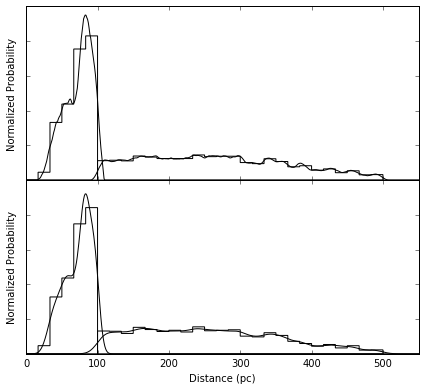

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5.5))

idx = reduce(np.intersect1d, 
             [np.where(dist_log_flat_good < 500.0)[0],
              np.where(s_log_flat_good < 5.0e4)[0],
              np.where(s_log_flat_good > 5.0e3)[0]])


dist_log_flat_100_kde = None
kwargs = {'kernel':'epanechnikov'}
dist_log_flat_100_kde = KernelDensity(bandwidth=10.0, **kwargs)
dist_log_flat_100_kde.fit( dist_log_flat_good[idx][dist_log_flat_good[idx]<100.0][:, np.newaxis] )

# dist_log_flat_100_kde = gaussian_kde(dist_log_flat_good[idx][dist_log_flat_good[idx]<100.0], bw_method=0.3)
dist_log_flat_200_kde = gaussian_kde(dist_log_flat_good[idx][dist_log_flat_good[idx]<200.0], bw_method=0.2)
dist_log_flat_500_kde = gaussian_kde(dist_log_flat_good[idx][dist_log_flat_good[idx]<500.0], bw_method=0.1)

idx_100_500 = np.intersect1d(np.where(dist_log_flat_good[idx]>100.0)[0], np.where(dist_log_flat_good[idx]<500.0)[0])
dist_log_flat_100_500_kde = KernelDensity(bandwidth=10.0, **kwargs)
dist_log_flat_100_500_kde.fit( dist_log_flat_good[idx][idx_100_500][:, np.newaxis] )
# dist_log_flat_100_500_kde = gaussian_kde(dist_log_flat_good[idx][idx_100_500], bw_method=0.1)


tmp_dist = np.linspace(0.0, 550.0, 500)
ax[0].hist(dist_log_flat_good[idx][dist_log_flat_good[idx]<100.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_100 = np.exp(dist_log_flat_100_kde.score_samples(tmp_dist[:, np.newaxis]))
#tmp_prob_log_flat_100 = dist_log_flat_100_kde(tmp_dist)

# ax[0].hist(dist_log_flat_good[idx][dist_log_flat_good[idx]<200.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_200 = dist_log_flat_200_kde(tmp_dist)
# ax[0].hist(dist_log_flat_good[idx][dist_log_flat_good[idx]<500.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_500 = dist_log_flat_500_kde(tmp_dist)
ax[0].hist(dist_log_flat_good[idx][idx_100_500], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_log_flat_100_500 = np.exp(dist_log_flat_100_500_kde.score_samples(tmp_dist[:, np.newaxis]))
# tmp_prob_log_flat_100_500 = dist_log_flat_100_500_kde(tmp_dist)




idx = reduce(np.intersect1d, 
             [np.where(dist_power_law_good < 500.0)[0],
              np.where(s_power_law_good < 5.0e4)[0],
              np.where(s_power_law_good > 5.0e3)[0]])

dist_power_law_100_kde = gaussian_kde(dist_power_law_good[idx][dist_power_law_good[idx]<100.0], bw_method=0.3)
dist_power_law_200_kde = gaussian_kde(dist_power_law_good[idx][dist_power_law_good[idx]<200.0], bw_method=0.2)
dist_power_law_500_kde = gaussian_kde(dist_power_law_good[idx][dist_power_law_good[idx]<500.0], bw_method=0.1)

idx_100_500 = np.intersect1d(np.where(dist_power_law_good[idx]>100.0)[0], np.where(dist_power_law_good[idx]<500.0)[0])
dist_power_law_100_500_kde = gaussian_kde(dist_power_law_good[idx][idx_100_500], bw_method=0.1)

ax[1].hist(dist_power_law_good[idx][dist_power_law_good[idx]<100.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_100 = dist_power_law_100_kde(tmp_dist) + dist_power_law_100_kde(1.0*100.0 - tmp_dist)
# ax[1].hist(dist_power_law_good[idx][dist_power_law_good[idx]<200.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_200 = dist_power_law_200_kde(tmp_dist) + dist_power_law_200_kde(1.0*100.0 - tmp_dist)
# ax[1].hist(dist_power_law_good[idx][dist_power_law_good[idx]<500.0], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_500 = dist_power_law_500_kde(tmp_dist) + dist_power_law_500_kde(1.0*100.0 - tmp_dist)
ax[1].hist(dist_power_law_good[idx][idx_100_500], histtype='step', color='k', bins=30, normed=True, range=(0,500))
tmp_prob_power_law_100_500 = dist_power_law_100_500_kde(tmp_dist) + dist_power_law_100_kde(1.0*100.0 - tmp_dist)



ax[0].plot(tmp_dist, tmp_prob_log_flat_100, color='k')
# ax[0].plot(tmp_dist, tmp_prob_log_flat_200, color='k')
# ax[0].plot(tmp_dist, tmp_prob_log_flat_500, color='k')
ax[0].plot(tmp_dist, tmp_prob_log_flat_100_500, color='k')
ax[1].plot(tmp_dist, tmp_prob_power_law_100, color='k')
# ax[1].plot(tmp_dist, tmp_prob_power_law_200, color='k')
# ax[1].plot(tmp_dist, tmp_prob_power_law_500, color='k')
ax[1].plot(tmp_dist, tmp_prob_power_law_100_500, color='k')


ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])

ax[0].set_xlim(0,550.0)
ax[1].set_xlim(0,550.0)

ax[1].set_xlabel('Distance (pc)')
ax[0].set_ylabel('Normalized Probability')
ax[1].set_ylabel('Normalized Probability')

plt.tight_layout()
plt.subplots_adjust(hspace=0)

plt.show()

In [6]:
dist_log_flat_100_500_kde.score_samples(150.0)

array([-5.76691902])

### Now, let's calculate all the functions needed for our model

In [9]:
def calc_integrand(dist, theta, dist_kde, alpha_1, alpha_2, s_crit):
    """
    This function is to calculate the integrand for the integral over distance
    
    Parameters
    ----------
    dist : float
        Distance (pc)
    theta : float
        Angular separation (arcsec)
    dist_kde : scipy gaussian_kde
        KDE based on the distance distribution observed
    alpha_1, alpha_2 : float
        Power law indices for s distribution
    s_crit : float
        Critical s defining the break in the power law
        
    Returns
    -------
    integrand : float
        Integrand of the equation
    
    """
    
    # Get the separation in Rsun
    s = (theta / 3600.0 * np.pi/180.0) * (dist * c.pc_to_cm / c.AU_to_cm)
        
    # Get probability from our broken power law model
    P_s = get_P_s(s, alpha_1, alpha_2, s_crit)

#     Projected separation is above 3.0e5 AU
#     P_s[np.where(s > 3.0e5)] = 0.0
    
    # Get the distance probability
    P_dist = dist_kde.evaluate((dist))

    # Calculate integrand
    integrand = P_s * dist * P_dist# * norm

    return integrand



def calc_integral(theta, dist_min, dist_max, dist_kde, alpha_1, alpha_2, s_crit):
    """
    Calculate the integral over distance of all binaries that 
    could match the observed angular separation, theta.
    
    Parameters
    ----------
    theta : float
        Angular separation (asec)
    dist_min, dist_max : float
        Min, max distance of integration
    dist_kde : scipy gaussian_kde
        KDE to represent distance distribution of a sample
    alpha_1, alpha_2 : float
        Power law indices for s distribution
    s_crit : float
        Critical s defining the break in the power law



    Returns
    -------
    P_theta : float
        Value of integration
    """
    
    args = theta, dist_kde, alpha_1, alpha_2, s_crit
        
    val = quad(calc_integrand, dist_min, dist_max, args=args, epsrel=1.0e-4)
    
    return val[0]


def calc_theta_norm(theta_min, theta_max, dist_min, dist_max, dist_kde, alpha_1, alpha_2, s_crit):
    """ Calculate the normalization constant, Z, for the integral
    
    Parameters
    ----------
    theta_min, theta_max : float
        Minimum and maximum angles for calculating the integrals
    dist_min, dist_max : float
        Minimum and maximum distances of the sample
    dist_kde : scipy gaussian_kde
        KDE to represent distance distribution of a sample
    alpha_1, alpha_2 : float
        Power law indices for s distribution
    s_crit : float
        Critical s defining the break in the power law


    Returns
    -------
    Z : float
        Normalization constant for the integral
    """
    
    args = dist_min, dist_max, dist_kde, alpha_1, alpha_2, s_crit
    
    norm = quad(calc_integral, theta_min, theta_max, args=args)
    
    return norm[0]
    
    
def get_P_s(s, alpha_1, alpha_2, s_crit):
    """ Calculate the non-normalized distribution 
    probability from a 2-component, broken power law
    
    Parameters
    ----------
    s : float
        Projected physical separation of the binary
    alpha_1, alpha_2 : float
        Power law indices for s distribution
    s_crit : float
        Critical s defining the break in the power law
        
    Returns
    -------
    P_s : float
        Probability of s    
    """
    
    if isinstance(s, np.ndarray):
        P_s = s**alpha_1
        P_s[s>s_crit] = s_crit**(alpha_1-alpha_2) * s[s>s_crit]**alpha_2
    else:
        if s < s_crit:
            P_s = s**alpha_1
        else:
            P_s = s_crit**(alpha_1-alpha_2) * s**alpha_2

    return P_s
    
    
def get_neg_log_likelihood(p, dist_kde_region_1, dist_kde_region_2, \
                           theta_region_1, theta_region_2):
    """ Calculate the likelihood function for a set of parameters and data
    
    Parameters
    ----------
    alpha_1, alpha_2 : float
        Power law indices for s distribution
    s_crit : float
        Critical s defining the break in the power law
    dist_kde_region_1, dist_kde_region_2 : scipy gaussian_kde
        KDEs to represent distance distribution of samples within Region 1 and 2
    theta_region_1, theta_region_2 : float
        Distribution of angular separations within Region 1 and 2
        
    Returns
    -------
    neg_ln_likelihood : float
        Negative of the log likelihood of the two data sets
    """

    alpha_1, alpha_2, s_crit = p
    
    # Region 1
    theta_min_region_1, theta_max_region_1 = 10.0, 600.0
    dist_min_region_1, dist_max_region_1 = 0.0, 100.0
    Z_const_1 = calc_theta_norm(theta_min_region_1, theta_max_region_1, \
                                dist_min_region_1, dist_max_region_1, \
                                dist_kde_region_1, alpha_1, alpha_2, s_crit)
    
    num_region_1 = len(theta_region_1)
    likelihood_1 = np.zeros(num_region_1)
    
    for i in np.arange(num_region_1):
        likelihood_1[i] = calc_integral(theta_region_1[i], dist_min_region_1, \
                                        dist_max_region_1, dist_kde_region_1, \
                                        alpha_1, alpha_2, s_crit)

        
        
        
    # Region 2
    theta_min_region_2, theta_max_region_2 = 10.0, 100.0
    dist_min_region_2, dist_max_region_2 = 100.0, 500.0
    Z_const_2 = calc_theta_norm(theta_min_region_2, theta_max_region_2, \
                                dist_min_region_2, dist_max_region_2, \
                                dist_kde_region_2, alpha_1, alpha_2, s_crit)
    
    num_region_2 = len(theta_region_2)
    likelihood_2 = np.zeros(num_region_2)
    
    for i in np.arange(num_region_2):
        likelihood_2[i] = calc_integral(theta_region_2[i], dist_min_region_2, \
                                        dist_max_region_2, dist_kde_region_2, \
                                        alpha_1, alpha_2, s_crit)

        
        
    neg_ll = -1.0 * (np.sum(np.log(likelihood_1)) + np.sum(np.log(likelihood_2)) + \
               - num_region_1 * np.log(Z_const_1) - num_region_2 * np.log(Z_const_2))
    
    print alpha_1, alpha_2, s_crit, neg_ll
    

    # Combine likelihoods
    return neg_ll

        

### Define the two regions for both samples

In [37]:
# Log flat sample
idx_log_flat_region_1 = reduce(np.intersect1d,
                               [np.where(dist_log_flat_good<100.0)[0],
                                np.where(TGAS_log_flat_good['theta'] > 10.0)[0],
                                np.where(TGAS_log_flat_good['theta'] < 600.0)[0]
                               ])
idx_log_flat_region_2 = reduce(np.intersect1d,
                               [np.where(dist_log_flat_good<500.0)[0], 
                                np.where(dist_log_flat_good>100.0)[0],
                                np.where(TGAS_log_flat_good['theta'] > 10.0)[0],
                                np.where(TGAS_log_flat_good['theta'] < 100.0)[0]
                               ])

theta_log_flat_region_1 = TGAS_log_flat_good['theta'][idx_log_flat_region_1]
theta_log_flat_region_2 = TGAS_log_flat_good['theta'][idx_log_flat_region_2]


# Power law sample
idx_power_law_region_1 = reduce(np.intersect1d,
                                [np.where(dist_power_law_good<100.0)[0],
                                 np.where(TGAS_power_law_good['theta'] > 10.0)[0],
                                 np.where(TGAS_power_law_good['theta'] < 600.0)[0]
                                ])
idx_power_law_region_2 = reduce(np.intersect1d,
                               [np.where(dist_power_law_good<500.0)[0], 
                                np.where(dist_power_law_good>100.0)[0],
                                np.where(TGAS_power_law_good['theta'] > 10.0)[0],
                                np.where(TGAS_power_law_good['theta'] < 100.0)[0]
                               ])

theta_power_law_region_1 = TGAS_power_law_good['theta'][idx_power_law_region_1]
theta_power_law_region_2 = TGAS_power_law_good['theta'][idx_power_law_region_2]

In [73]:
# Starting values
alpha_1 = -1.0
alpha_2 = -1.6
s_crit = 2.0e3


dist = np.arange(10, 90, 10)
theta = 50.0
print calc_integrand(dist, theta, dist_power_law_100_500_kde, alpha_1, alpha_2, s_crit)

print calc_integral(theta, 0.0, 100.0, dist_power_law_100_500_kde, alpha_1, alpha_2, s_crit)
print calc_theta_norm(10.0, 100.0, 100, 500, dist_power_law_100_500_kde, alpha_1, alpha_2, s_crit)

print get_likelihood(alpha_1, alpha_2, s_crit, dist_power_law_100_kde, dist_power_law_500_kde, \
                     theta_power_law_region_1, theta_power_law_region_2)

[  8.64146164e-25   7.28711780e-21   2.18424189e-17   2.33752094e-14
   7.86462223e-12   9.84335363e-10   4.61997260e-08   8.30638470e-07]
0.000149450576225
1.12132295649
-11393.9016103


In [87]:
# Starting values
alpha_1 = -1.0
alpha_2 = -1.6
s_crit = 2.0e3

x0 = np.array([alpha_1, alpha_2, s_crit])
args = dist_power_law_100_kde, dist_power_law_500_kde, theta_power_law_region_1, theta_power_law_region_2

bounds = ([-3.0, -1.0e-5], [-3.0, -1.0e-5], [1.0, 1.0e5])
print minimize(get_neg_log_likelihood, x0, args=args, method='L-BFGS-B', bounds=bounds)

-1.0 -1.6 2000.0 11393.9016103
-0.99999999 -1.6 2000.0 11393.90161
-1.0 -1.59999999 2000.0 11393.9016068
-1.0 -1.6 2000.00000001 11393.9016103
-1e-05 -1e-05 2000.02437446 12550.52968
-9.99e-06 -1e-05 2000.02437446 12550.5296809
-1e-05 -9.99e-06 2000.02437446 12550.5296971
-1e-05 -1e-05 2000.02437447 12550.52968
-0.837489215955 -1.33998177045 2000.00396115 11341.2780004
-0.837489205955 -1.33998177045 2000.00396115 11341.2780005
-0.837489215955 -1.33998176045 2000.00396115 11341.278
-0.837489215955 -1.33998177045 2000.00396116 11341.2780004
-0.836865507963 -1.31109566509 2000.00428086 11340.6086036
-0.836865497963 -1.31109566509 2000.00428086 11340.6086038
-0.836865507963 -1.31109565509 2000.00428086 11340.6086036
-0.836865507963 -1.31109566509 2000.00428087 11340.6086036
-0.854581048466 -1.30512580187 2000.00422558 11340.3543233
-0.854581038466 -1.30512580187 2000.00422558 11340.3543234
-0.854581048466 -1.30512579187 2000.00422558 11340.3543233
-0.854581048466 -1.30512580187 2000.004225

/Library/Python/2.7/site-packages/scipy/integrate/quadpack.py:357: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [88]:
# Starting values
alpha_1 = -1.0
alpha_2 = -1.6
s_crit = 4.0e3

x0 = np.array([alpha_1, alpha_2, s_crit])
args = dist_power_law_100_kde, dist_power_law_500_kde, theta_power_law_region_1, theta_power_law_region_2

bounds = ([-3.0, -1.0e-5], [-3.0, -1.0e-5], [1.0, 1.0e5])
print minimize(get_neg_log_likelihood, x0, args=args, method='L-BFGS-B', bounds=bounds)

-1.0 -1.6 4000.0 11349.8233715
-0.99999999 -1.6 4000.0 11349.8233711
-1.0 -1.59999999 4000.0 11349.8233701
-1.0 -1.6 4000.00000001 11349.8233715
-1e-05 -1e-05 4000.00945874 12550.52968
-9.99e-06 -1e-05 4000.00945874 12550.529683
-1e-05 -9.99e-06 4000.00945874 12550.529695
-1e-05 -1e-05 4000.00945875 12550.52968
-0.907408726564 -1.45185340695 4000.00087581 11335.6508783
-0.907408716564 -1.45185340695 4000.00087581 11335.6508784
-0.907408726564 -1.45185339695 4000.00087581 11335.650878
-0.907408726564 -1.45185340695 4000.00087582 11335.6508783
-0.920128955756 -1.42048180313 4000.00097305 11334.9595329
-0.920128945756 -1.42048180313 4000.00097305 11334.959533
-0.920128955756 -1.42048179313 4000.00097305 11334.9595328
-0.920128955756 -1.42048180313 4000.00097306 11334.9595329
-0.965560577234 -1.38962900757 4000.00099264 11334.3235558
-0.965560567234 -1.38962900757 4000.00099264 11334.3235559
-0.965560577234 -1.38962899757 4000.00099264 11334.3235559
-0.965560577234 -1.38962900757 4000.0009

In [3]:
model_s = np.load('../data/TGAS/model_s_dist_log_flat.npy')

In [5]:
print model_s.shape


(2000, 3)


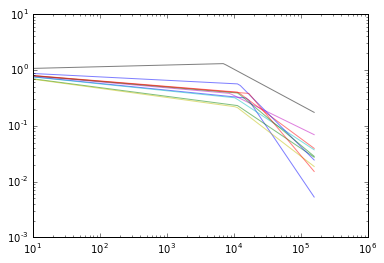

In [14]:
s_all = 10**np.linspace(1,5.2, 100)

p_s = np.zeros(len(s_all))

for i in np.random.randint(len(model_s), size=10):
    p = model_s[i]

    for i, s in zip(np.arange(len(s_all)), s_all):
        p_s[i] = get_P_s(s, p[0], p[1], p[2]) * s_all[i]
    
    plt.plot(s_all, p_s, alpha=0.5)

    
    
    
plt.yscale('log')
plt.xscale('log')
plt.show()

[ -1.11401924e+00  -1.97201940e+00   1.15121535e+04]
